# Shakespeare - text generation
 - doc: https://github.com/openaiknowledge/PR2
 - based on: https://www.kaggle.com/kutaykutlu/text-generation-guide-tensorflow-nlp-lstm

# Import Libraries

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow import keras
import tensorflow.keras.utils 
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy as np

from google.colab import drive

# Load Dataset

In [18]:
BASE_FOLDER = '/content/drive/My Drive/openaiknowledge/pr2/'
DATA = BASE_FOLDER + 'data/1/' #version 1
MODEL = BASE_FOLDER + "model/1/"

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#todo: use metada.json
datafile_name = DATA + "Shakespeare_data.csv"
print(datafile_name)
df = pd.read_csv(datafile_name)
df.head(1)

/content/drive/My Drive/openaiknowledge/pr2/data/1/Shakespeare_data.csv


,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I


In [6]:
import csv

corpus = []

#with open('/kaggle/input/shakespeare-plays/Shakespeare_data.csv') as f:
with open(datafile_name) as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)        # to pass first row,header
    for row in reader:
        corpus.append(row[5])
        
print(len(corpus))
print(corpus[:3])

111396
['ACT I', 'SCENE I. London. The palace.', 'Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others']


# Data Cleaning

In [7]:
import string

def text_cleaner(text):
    text = "".join(car for car in text if car not in string.punctuation).lower()
    text = text.encode("utf8").decode("ascii",'ignore')
    return text

corpus = [text_cleaner(line) for line in corpus]


In [8]:
# Tokenization is the process of splitting up a text into a list of individual words, or tokens.
# corpus is too big if you try with all data, you can see this message
# Your notebook tried to allocate more memory than is available. It has restarted.
corpus = corpus[:5000]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_words = len(word_index) + 1
total_words

5411

![Tokenization](https://blog.floydhub.com/content/images/2020/02/tokenize.png)

In [9]:
# create input sequences using list of tokens
input_sequences =[]

for sentence in corpus:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        

In [10]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, 
                                         padding='pre')) # as laste value is label.padding method is 'pre'

- __Sequences__ and __n_Gram_squences__ for a sentence after __Padding__

- Last value for every line is target, label. 

- line1 : 2

- line2 : 66

![n_gram](https://gurubux.files.wordpress.com/2019/09/input_sequences_padded.jpg?w=641)

In [11]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
# create one-hot encoding of the labels
label = tensorflow.keras.utils.to_categorical(label, num_classes=total_words)

In [12]:
print(label[0])
print(label[0].shape)

[0. 0. 0. ... 0. 0. 0.]
(5411,)


In [13]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 10)            54110     
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2142208   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5411)              5546275   
Total params: 7,742,593
Trainable params: 7,742,593
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
 history = model.fit(predictors, label, epochs=50,  verbose=1)

Epoch 1/50
1026/1026 [==============================] - 30s 22ms/step - loss: 6.8217 - accuracy: 0.0383
Epoch 2/50
1026/1026 [==============================] - 22s 22ms/step - loss: 6.4586 - accuracy: 0.0496
Epoch 3/50
1026/1026 [==============================] - 22s 22ms/step - loss: 6.3121 - accuracy: 0.0531
Epoch 4/50
1026/1026 [==============================] - 22s 22ms/step - loss: 6.1312 - accuracy: 0.0613
Epoch 5/50
1026/1026 [==============================] - 22s 22ms/step - loss: 5.9078 - accuracy: 0.0731
Epoch 6/50
1026/1026 [==============================] - 22s 22ms/step - loss: 5.6492 - accuracy: 0.0828
Epoch 7/50
1026/1026 [==============================] - 22s 22ms/step - loss: 5.3462 - accuracy: 0.0923
Epoch 8/50
1026/1026 [==============================] - 23s 22ms/step - loss: 5.0008 - accuracy: 0.1067
Epoch 9/50
1026/1026 [==============================] - 23s 22ms/step - loss: 4.6273 - accuracy: 0.1372
Epoch 10/50
1026/1026 [==============================] - 23s 22m

In [19]:
#save model
model_name = "shakespeare_text"
model_file_name =  MODEL + model_name + '.h5'
model.save(model_file_name)

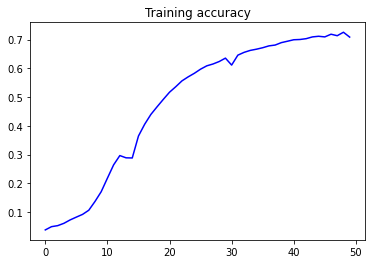

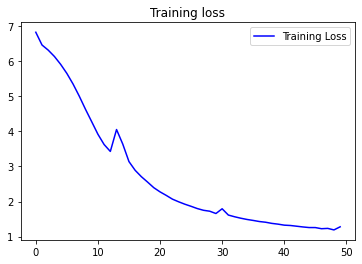

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [26]:
next_words = 50

def generate_txt(model, seed_text): 
  for _ in range(next_words):
      token_list = tokenizer.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
      predicted = model_saved.predict_classes(token_list, verbose=0)
      output_word = ""
      for word, index in tokenizer.word_index.items():
          if index == predicted:
              output_word = word
              break
      seed_text += " " + output_word
      if len(seed_text) % 10 == 0 :
          seed_text+= '\n'
  print(seed_text)

In [ ]:
model_saved = keras.models.load_model(model_file_name)

In [27]:
seed_text = "Somewhere in La Mancha,"
generate_txt(model_saved, seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Somewhere in La Mancha, battles salisbury oercame my own lord in spent
 you when
 i meet me and i were a hundred to them
 runs and
 leaving the booty behind them leaving the walls behind them they la joan la charles charles alencon and others after it by them and vernon
 after them exeter
